In [1]:
%run -i 'src/SPV.py'
from src.data_functions import *
from src.solution_algorithms import *

In [2]:
df = pd.read_csv('data/full_randomized_2017_hourly_normalized_v2.csv')
df.head()

,dataid,localhour,use,gen_per_kW
0,26,2017-01-01 00:00:00,1.788817,0.0
1,26,2017-01-01 01:00:00,1.223917,0.0
2,26,2017-01-01 02:00:00,0.668367,0.0
3,26,2017-01-01 03:00:00,0.478667,0.0
4,26,2017-01-01 04:00:00,0.416283,0.0


In [3]:
dataids = obtain_dataid_2017(df)
dataids_array = np.asarray(dataids)
validdata = len(dataids)
T = len(df[df.dataid==26].use.values)

In [4]:
gen_kw = f_gen_per_kw(df)
load_kw = f_load_kw(df)

1 m$^2$ is 1550 in$^2$

Typical size of solar panel: is 65 in for 39 in = 2535 in$^2$ = 1.6354 m$^2$.

The rated power of a solar panel is typically between 250 to 350W.

To convert we use: gen_per_kw by 0.3 / 1.6354 to get gen_per_m$^2$.

In [5]:
gen_per_m2 = gen_kw*0.3/1.6354

In [6]:
#Investment per m2 is 512.2 $/m2.
#Using an anualized cost with discount rate r=5%, we obtain
CostPVperM2 = 512.2
r = 0.05
years = 20
annuity = CostPVperM2*r/(1-(1+r)**(-years)) #Obtain Annuity 
pi_s = annuity/T #Obtain cost per time step
print('Cost of PV per time step: ' + str(pi_s))

Cost of PV per time step: 0.004695025492240356


In [7]:
firms = validdata #Number of firms
gamma = 1 #Factor of NM price
pi_r = 0.18   #Retail Price at 18 cents per kWh.
pi_nm = gamma*pi_r  #Net Metering Price
a_cap_firms = f_cap_firms(gen_per_m2, load_kw) #Cap for firms to not be net producers
a_max_firms = 0.2*a_cap_firms

In [11]:
pv_changes = []
gamma = np.linspace(0,1,21)
for g in gamma:
    pi_nm = g*pi_r
    %run -i 'src/Case_01.py'
    pv_changes.append(aux)
    clear_output()

In [8]:
gamma = np.linspace(0,1,21)

In [12]:
print(pv_changes)

[1.0593219081332161, 1.0315641915037417, 1.0024351906111129, 0.9698924657036252, 0.9350390289445311, 0.8987029117955894, 0.8593924626548064, 0.8186130301240024, 0.7747903624227751, 0.7267145228621336, 0.6759769283964651, 0.6213546043226311, 0.5637410220699046, 0.496885576479962, 0.4257993862328348, 0.34744581133312286, 0.26839341714819137, 0.19236603434144148, 0.11984696768468528, 0.06049558634971119, 0.0]


In [13]:
pv_changes_case01 = [1.0593219081332161, 1.0315641915037417, 1.0024351906111129, 0.9698924657036252, 0.9350390289445311, 0.8987029117955894, 0.8593924626548064, 0.8186130301240024, 0.7747903624227751, 0.7267145228621336, 0.6759769283964651, 0.6213546043226311, 0.5637410220699046, 0.496885576479962, 0.4257993862328348, 0.34744581133312286, 0.26839341714819137, 0.19236603434144148, 0.11984696768468528, 0.06049558634971119, 0.0]

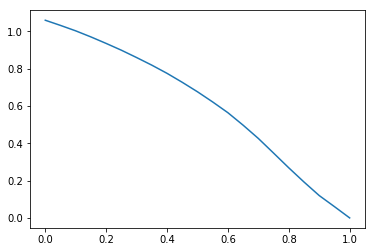

In [14]:
plt.plot(gamma, pv_changes)

In [ ]:
investment_standalone = solve_standalone(gen_per_m2, load_kw, dataids, a_max_firms, pi_s, pi_r, pi_nm)

In [ ]:
print('\n')
print('Investment decisions:')
print(investment_standalone) #Print investment decisions
print('\n')
print('Percentage of investment per firm (with respect to max_cap)')
print(1-(a_max_firms - investment_standalone)/a_max_firms) #Print percentage of investment of available max cap
print('\n Total Investment of PV in standalone case is '+ str(sum(investment_standalone)) + ' in m2 \n')

In [ ]:
soluc_sharing = solve_sharing_collective(gen_per_m2, load_kw, dataids_array, a_max_firms, pi_s, pi_r)
sol_sharing = firms_investment_sharing(soluc_sharing, a_max_firms, firms)

In [ ]:
def f_collective_load(load_kw):
    return np.sum(load_kw, axis=1)

def f_collective_gen(gen_per_m2, area_invested):
    aux = gen_per_m2 * area_invested
    return np.sum(aux, axis=1)

def f_hours_collective_net_load_negative(collective_load, collective_gen):
    net_load = collective_load - collective_gen
    aux = net_load < 0
    return np.sum(aux)

In [ ]:
coll_load = f_collective_load(load_kw)
coll_gen = f_collective_gen(gen_per_m2, sol_sharing)
hours_neg = f_hours_collective_net_load_negative(coll_load, coll_gen)

In [ ]:
(np.sum(sol_sharing) - np.sum(investment_standalone))/np.sum(investment_standalone)

In [ ]:
np.sum(aux, axis=1).shape

In [ ]:
df2 = pd.read_csv('data/LMP_2017_data.csv')
pi_g = f_lmp_prices(df2) #Data is in $/MWh
pi_g = pi_g/1000 # convert to $/kWh

In [ ]:
pi_g2 = pi_g
soluc_wholesale = solve_wholesale_aggregator(gen_per_m2, load_kw, a_max_firms, pi_s, pi_g2)
print(soluc_wholesale)

In [ ]:
avg_profit_nopv = utility_profit_no_investment(load_kw, pi_r)

In [ ]:
avg_profit_standalone = utility_profit_standalone(gen_per_m2, load_kw, investment_standalone, pi_r, pi_nm)

In [ ]:
avg_profit_sharing = utility_profit_sharing(gen_per_m2, load_kw, sol_sharing, pi_r)

In [ ]:
print(annuity)

In [ ]:
df2.head(10)

In [ ]:
df3 = df2.groupby(['OPR_HR']).mean()
print(df3)

In [ ]:
df4 = df2.mean()

In [ ]:
print(df4)